In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer, confusion_matrix
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, SelectK2Last, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.classified_regression import ClassifiedRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [2]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [3]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]
# Gargage collection
del trn
del trn_comb
# Timing
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 11.8589 secs


In [4]:
# Add deterministic estimator as columns
# MP params=0.82
trn_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
trn_withRef_comb.loc[:,'KDP'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
trn_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
trn_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,trn_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    trn_withRef_comb.loc[trn_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])

In [5]:
# Extract X and y
y = trn_withRef_comb['Expected_mean']
X = trn_withRef_comb.ix[:, [col for col in trn_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
# Garbage collection
del trn_withRef_comb
print X.shape, y.shape

(731556, 136) (731556,)


In [6]:
n_tree = 500
n_thread = 7
filter_th = 45
# Mixed up
lpo1 = LogPlusOne()
imp1 = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss1 = StandardScaler(copy=False, with_mean=True, with_std=True)
reg1 = xgb.sklearn.XGBRegressor(n_estimators=n_tree, nthread=n_thread)
pip1 = Pipeline([('lpo', lpo1), ('imp', imp1), ('ss', ss1), ('reg', reg1)], copy=True)
# lowlow, lowhigh
ttf2 = TargetThresholdFilter(threshold=filter_th )
lpo2 = LogPlusOne()
imp2 = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss2 = StandardScaler(copy=False, with_mean=True, with_std=True)
reg2 = xgb.sklearn.XGBRegressor(n_estimators=n_tree, nthread=n_thread)
pip2 = Pipeline([('ttf', ttf2), ('lpo', lpo2), ('imp', imp2), ('ss', ss2), ('reg', reg2)], copy=True)
# lowlow, highhigh
lpo3 = LogPlusOne()
imp3 = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss3 = StandardScaler(copy=False, with_mean=True, with_std=True)
clf3 = xgb.sklearn.XGBClassifier(n_estimators=n_tree, nthread=n_thread)
reg31 = xgb.sklearn.XGBRegressor(n_estimators=n_tree, nthread=n_thread)
reg32 = xgb.sklearn.XGBRegressor(n_estimators=n_tree, nthread=n_thread)
reg3 = ClassifiedRegressor(labeling_thresh=np.log10(1+filter_th) , classifier=clf3, proba_thresh=0.5, regressors=(reg31, reg32), verbose=1)
pip3 = Pipeline([('lpo', lpo3), ('imp', imp3), ('ss', ss3), ('reg', reg3)], copy=True)
def LogPlusOne_score(ground_truth, predictions, lpo=None):
    tmp = np.abs(ground_truth - (np.power(10, predictions) - 1))
    idx = tmp.argmax()
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

In [7]:
[X_trn, X_val, y_trn, y_val] = train_test_split(X, y, test_size = 0.2)

232.078109026
22.8381770748


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


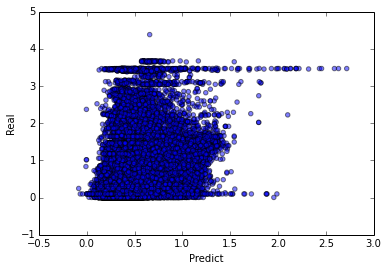

In [8]:
t = time.time()
pip1.fit(X_trn, y_trn)
y_val_lpo_predict_1 = pip1.predict(X_val)
print time.time()-t
plt.scatter(y_val_lpo_predict_1, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict_1)

248.692878008
22.7917946927


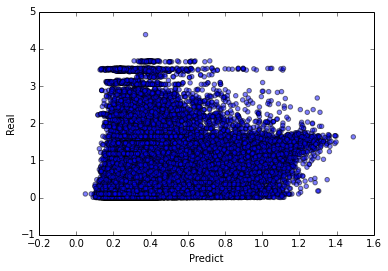

In [9]:
t = time.time()
pip2.fit(X_trn, y_trn)
y_val_lpo_predict_2 = pip2.predict(X_val)
print time.time()-t
plt.scatter(y_val_lpo_predict_2, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict_2)

585244 569140 16104  
146312 146186 126  
501.956592083
22.4868567929


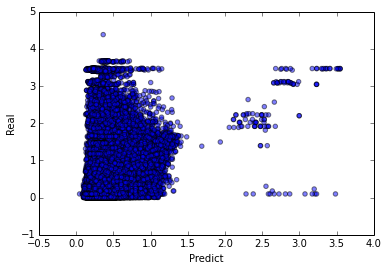

In [10]:
t = time.time()
pip3.fit(X_trn, y_trn)
y_val_lpo_predict_3 = pip3.predict(X_val)
print time.time()-t
plt.scatter(y_val_lpo_predict_3, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict_3)

In [16]:
pip3_sub = Pipeline([('lpo', lpo3), ('imp', imp3), ('ss', ss3), ('clf', pip3.steps[3][1].classifier)], copy=True)
y_label_val_predict_prob = pip3_sub.predict_proba(X_val)[:, 0]
score = []
rg = np.arange(0.5, 0.71, 0.01)
for i, th in enumerate(rg):
    c = confusion_matrix(y_val>filter_th, y_label_val_predict_prob<th)
    pip3.steps[3][1].proba_thresh = th
    
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    pip3.steps[3]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===score {}".format(th, TP, FN, TN, FP, LogPlusOne_score(y_val, pip3.predict(X_val)))

146312 146186 126  
=====th = 0.5=====(TP 105, FN 3946, TN 142240, FP 21)===score 22.4868567929
146312 146174 138  
=====th = 0.51=====(TP 114, FN 3937, TN 142237, FP 24)===score 22.4692869679
146312 146166 146  
=====th = 0.52=====(TP 120, FN 3931, TN 142235, FP 26)===score 22.4369681484
146312 146162 150  
=====th = 0.53=====(TP 124, FN 3927, TN 142235, FP 26)===score 22.4364104442
146312 146152 160  
=====th = 0.54=====(TP 130, FN 3921, TN 142231, FP 30)===score 22.436619167
146312 146146 166  
=====th = 0.55=====(TP 135, FN 3916, TN 142230, FP 31)===score 22.4033893194
146312 146140 172  
=====th = 0.56=====(TP 140, FN 3911, TN 142229, FP 32)===score 22.3963995097
146312 146133 179  
=====th = 0.57=====(TP 146, FN 3905, TN 142228, FP 33)===score 22.3730978518
146312 146122 190  
=====th = 0.58=====(TP 149, FN 3902, TN 142220, FP 41)===score 22.3771477311
146312 146111 201  
=====th = 0.59=====(TP 157, FN 3894, TN 142217, FP 44)===score 22.3997389284
146312 146101 211  
=====th = 0.